# Visualizing Aggregates

This demo shows how to query statistical aggregates computed at different levels of granularity, and how to visualize aggregate data over long time series.

The same basic concepts underlying this tutorial can be used in machine learning workflows.


In [1]:
import btrdb
import pandas as pd
import numpy as np

import time
import os

from datetime import datetime, timedelta

from matplotlib import pyplot as plt
from btrdb.utils.timez import *

**Connect to database server**

In [2]:
db = btrdb.connect('api.ni4ai.org:4411', apikey=os.environ['BTRDB_API_KEY'])
# db = btrdb.connect()

**Helper Functions**

In [3]:
def points_to_dataframe(points, 
                        aggregates=['time','min','max','mean','stddev','count'],
                        datetime_index=True):
    
    if type(points[0]) == tuple:
        points, _ = zip(*points)

    df = pd.DataFrame([[getattr(pt, agg) for agg in aggregates] for pt in points],
                     columns=aggregates)

    if datetime_index:
        df['datetime'] = [ns_to_datetime(t) for t in df.time]
        df = df.set_index('datetime')
    return df

def visualize_aggregates(df):
    fig, ax = plt.subplots(figsize=(15,4))

    df['mean'].plot(ls=' ', marker='.', color='b', label='mean', ax=ax)
    ax.fill_between(df.index, df['min'], df['max'], color='b', alpha=0.2)
    ax.set_ylabel('Voltage (volts)')
    ax.set_xlabel('Time')
    
def create_histogram(raw_values):
    
    fig, ax = plt.subplots(figsize=(6,3))
    ax.hist([v.value for v, _ in raw_values], bins=50)
    ax.set_xlabel('Voltage (volts)')
    ax.set_title('Histogram of Raw Points')
    plt.show()


def summarize_aggregates(statpoints):
    print("""
    Aggregates
        min: %.2f
        mean: %.2f
        max: %.2f
    """%(statpoints[0][0].min, statpoints[0][0].mean, statpoints[0][0].max))

    print("""
    Point counts
        number of stat points: %i
        number of raw points: %i
    """%(len(statpoints), statpoints[0][0].count))

### Choosing a stream

We have already demonstrated how to choose streams. Here we'll select one at random.

In [4]:
streams = db.streams_in_collection('sunshine/PMU1', tags={'unit': 'volts'})
stream = streams[0]
stream

<Stream collection=sunshine/PMU1 name=L3MAG>

### What's in a stream?

Here we extract information about the stream -- such as the start and end time, and number of points. You can also pull up the stream in the plotter:
https://plot.ni4ai.org/permalink/_oFJLsrlk

In [5]:
earliest, _ = stream.earliest()
latest, _ = stream.latest()

earliest_time = ns_to_datetime(earliest.time)
latest_time = ns_to_datetime(latest.time)

stream_info = {'Collection': stream.collection,
               'Name':       stream.name,
               'Units':      stream.unit,
               'Start time': str(earliest_time),
               'End time':   str(latest_time),
               'Duration':   str(latest_time-earliest_time),
               'N Points':   stream.count()}

stream_info

{'Collection': 'sunshine/PMU1',
 'Name': 'L3MAG',
 'Units': 'volts',
 'Start time': '2015-10-01 16:08:24.008333+00:00',
 'End time': '2017-04-15 01:41:35.999999+00:00',
 'Duration': '561 days, 9:33:11.991666',
 'N Points': 5143199721}

## Refresher on StatPoints

StatPoints report statistical aggregates of raw values within user-defined time intervals. Here are two examples generating StatPoints that report aggregates at different resolutions:
- 1 minute
- 5 minutes
- 8 minutes

Plotting the histogram of raw values provides intuition about what StatPoints report. Below, we'll show how querying aggregates at various resolutions can enable fast queries over long time series of data.


    Aggregates
        min: 7127.12
        mean: 7146.07
        max: 7153.44
    

    Point counts
        number of stat points: 1
        number of raw points: 7200
    


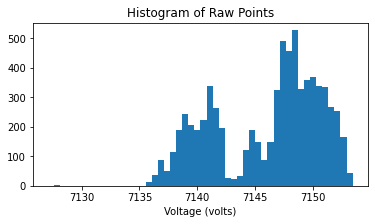

In [7]:
dt = ns_delta(minutes=1)
end = stream.latest()[0].time

statpoints = stream.windows(end-dt, end, dt)
summarize_aggregates(statpoints)

raw_values = stream.values(end-dt, end)
create_histogram(raw_values)



    Aggregates
        min: 7103.70
        mean: 7137.49
        max: 7153.44
    

    Point counts
        number of stat points: 1
        number of raw points: 36000
    


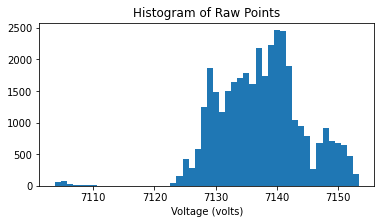

In [8]:
dt = ns_delta(minutes=5)

statpoints = stream.windows(end-dt, end, dt)
summarize_aggregates(statpoints)

raw_values = stream.values(end-dt, end)
create_histogram(raw_values)



    Aggregates
        min: 7103.70
        mean: 7136.92
        max: 7153.44
    

    Point counts
        number of stat points: 1
        number of raw points: 72000
    


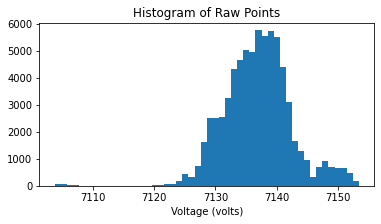

In [9]:
dt = ns_delta(minutes=10)

statpoints = stream.windows(end-dt, end, dt)
summarize_aggregates(statpoints)

raw_values = stream.values(end-dt, end)
create_histogram(raw_values)

# Generating a time series of aggregates

Above, we demonstrated the use of "windows" queries to generate stat points reporting aggregates at arbitrary temporal resolution. Here, we'll do the same looking at much longer measurement intervals.

We'll look at 1-year of data from April 2016 to April 2017.

In [10]:
start_time = datetime(2016, 4, 1)
end_time = datetime(2017, 4, 1)

# convert datetimes to nanoseconds
start_ns = datetime_to_ns(start_time)
end_ns = datetime_to_ns(end_time)

### Weekly aggregates

Querying one year of data in 7-day time windows returns 52 statpoints.

Time resolution: 7 days


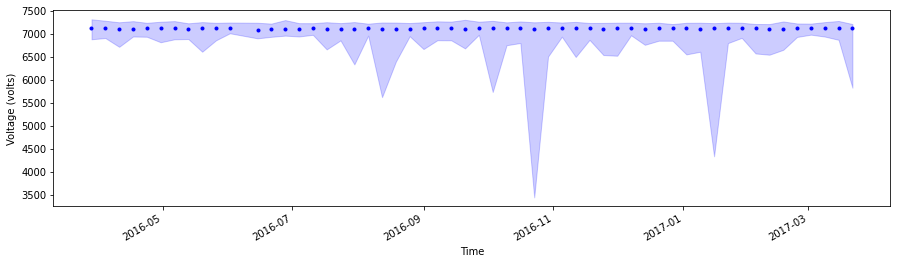

In [11]:
time_window = ns_delta(days=7)
points = stream.aligned_windows(start_ns, end_ns, np.log2(time_window))

print('Time resolution: 7 days')
df = points_to_dataframe(points)
visualize_aggregates(df)

Time resolution: 1 day


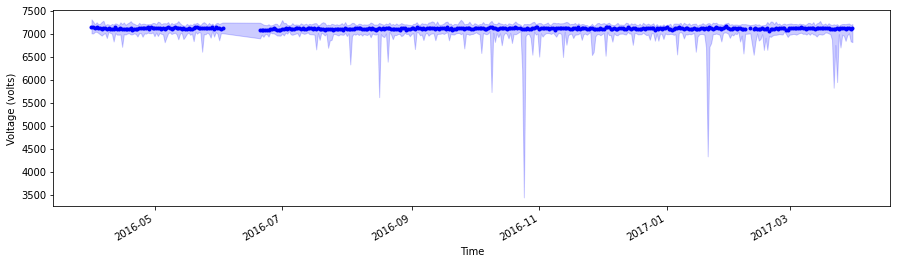

In [12]:
time_window = ns_delta(days=1)
points = stream.aligned_windows(start_ns, end_ns, np.log2(time_window))

print('Time resolution: 1 day')

df = points_to_dataframe(points)
visualize_aggregates(df)

Time resolution: 6 hours


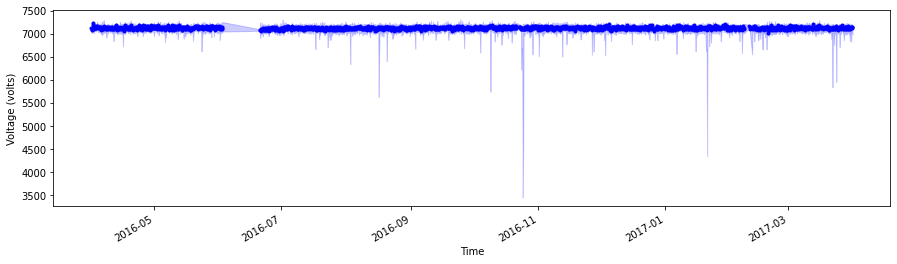

In [13]:
time_window = ns_delta(hours=6)
points = stream.aligned_windows(start_ns, end_ns, np.log2(time_window))

print('Time resolution: 6 hours')

df = points_to_dataframe(points)
visualize_aggregates(df)

## Using aggregates to visualize the likelihood of observed values
In this visualization, we query raw points as well as the aggregate statistics covering 1 second windows. We then use the mean and standard deviation aggregates for a given 1 second window to compute the likelihood of each raw point in that window. We visualize the raw points in a scatter plot, where their color indicates their probability.

This visualization illustrates how aggregate statistics are powerful for effeciently localizing statistical anomalies in the data and understanding the degree of anomalousness. 

Step 1: Two methods to convert the results of a query to dataframes. One is for raw point queries, and the other is for aggregate queries. 

In [14]:
def points_to_dataframe(points, 
                        aggregates=['time','min','max','mean','stddev','count'],
                        use_datetime_index=True):
    df = pd.DataFrame([[getattr(p, agg) for agg in aggregates] for p in points],
                         columns=aggregates)
    if use_datetime_index:
        df['datetime'] = [ns_to_datetime(t) for t in df.time]
        df = df.set_index('datetime')
    return df

def raw_points_to_dataframe(points, use_datetime_index=True): 
    aggregates=['time', 'value']
    df = pd.DataFrame([[getattr(p, agg) for agg in aggregates] for p in points],
                         columns=aggregates)
    if use_datetime_index:
        df['datetime'] = [ns_to_datetime(t) for t in df.time]
        df = df.set_index('datetime')
    return df

Step 2: Choose a stream and time range to query. 

In [15]:
stream = streams[0]
start_time = datetime(2016,8,16, 18, 45)
end_time = start_time + timedelta(minutes=10)

Step 3: Query the data. 

In [16]:
# Get raw points over this range
points, _ = zip(*stream.values(start_time, end_time)); 
raw_df = raw_points_to_dataframe(points); 

# Get aligned windows stats over this range
window = ns_delta(minutes=2)

points, _ = zip(*stream.windows(start_time, end_time, window))
agg_df = points_to_dataframe(points)

Step 4: Compute likelihoods. 

In [17]:
raw_times = raw_df.index; 
raw_array = raw_df.values[:, 1]; 
agg_array = agg_df.values[:, 1:]; 

[n_wins, n_stats] = np.shape(agg_array)
n_samples = np.size(raw_array); 

# Compute probabilities assuming a normal distribution
# with mean and std. dev. given by the aggregate values. 
probs = np.zeros(n_samples)

n_win = int(n_samples / n_wins); 
for w in range(n_wins): 
    mu = agg_array[w, 2];
    sig = agg_array[w, 3]; 
    x = raw_array[w*n_win : (w+1)*n_win]; 
    probs[w*n_win : (w+1)*n_win] = (1/(sig*np.sqrt(2*np.pi)))*np.exp(-0.5 * ((x - mu) / sig)**2)

Step 5: Visualize! 

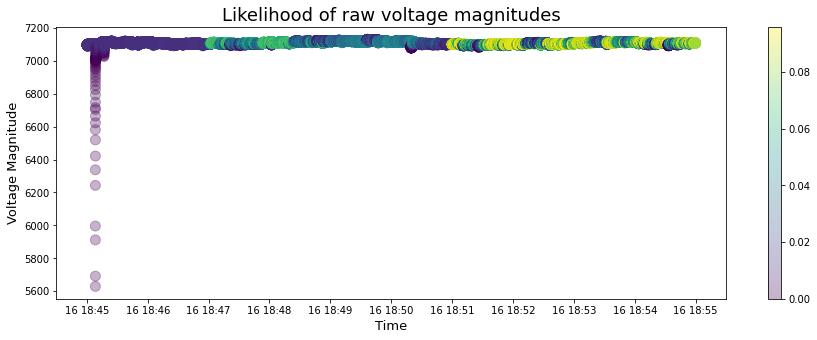

In [18]:
plt.figure(figsize=(15, 5))
plt.scatter(raw_times, raw_array, s=100, c=probs, alpha=0.3);
plt.colorbar(); 
plt.title('Likelihood of raw voltage magnitudes', fontsize=18);
plt.ylabel('Voltage Magnitude', fontsize=13); 
plt.xlabel('Time', fontsize=13); 